<a href="https://colab.research.google.com/github/qhung23125005/AIO/blob/main/AIO24/Module6/RNN/SentimentAnalysisForFinancialNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 7.8 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Data

##Download data

In [4]:
!gdown 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q

Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: /content/dataset.zip
100% 230k/230k [00:00<00:00, 5.34MB/s]


In [5]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/all-data.csv    


##Load data

In [67]:
dataset_path = './dataset/all-data.csv'
headers = ['sentiment', 'content']

df = pd.read_csv(
    dataset_path,
    names=headers,
    encoding = 'ISO-8859-1'
)

df

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [68]:
classes = {
    class_name: idx
    for idx, class_name in enumerate(df.sentiment.unique().tolist())
}

df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])

classes

{'neutral': 0, 'negative': 1, 'positive': 2}

##Preprocess

In [69]:
english_stopwords = stopwords.words('english')
stemmer = PorterStemmer()

def normalize_text(text):
  text = text.lower()
  text = unidecode.unidecode(text)
  text = re.sub(r'[^\w\s]', '', text)
  text = ' '.join([
      word for word in text.split(' ') if word not in english_stopwords
  ])
  text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
  return text

In [70]:
df['content'] = df['content'].apply(lambda x: normalize_text(x))
df

,sentiment,content
0,0,accord gran compani plan move product russia ...
1,0,technopoli plan develop stage area less 100000...
2,1,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increas capac ...
4,2,accord compani updat strategi year 20092012 b...
...,...,...
4841,1,london marketwatch share price end lower lond...
4842,0,rinkuskiai beer sale fell 65 per cent 416 mill...
4843,1,oper profit fell eur 354 mn eur 688 mn 2007 i...
4844,1,net sale paper segment decreas eur 2216 mn sec...


##Create dictionary

In [71]:
vocab = []

for sentence in df['content'].tolist():
  tokens = sentence.split(' ')
  for token in tokens:
    if token not in vocab:
      vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

vocab_size

8909

##Create transform text to tokens

In [72]:
def transform(text, word_to_idx, max_seq_len):
  tokens = []
  for token in text.split(' '):
    try:
      w_idx = word_to_idx[token]
    except:
      w_idx = word_to_idx['UNK']
    tokens.append(w_idx)

  if len(tokens) < max_seq_len:
    tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
  elif len(tokens) > max_seq_len:
    tokens = tokens[:max_seq_len]

  return tokens

##Split train, val, test

In [82]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

##Create Pytorch Dataset

In [83]:
class FinancialNews(Dataset):
  def __init__(
      self, X, y,
      word_to_idx, max_seq_len,
      transform = None
    ):
    self.texts = X
    self.labels = y
    self.word_to_idx = word_to_idx
    self.max_seq_len = max_seq_len
    self.transform = transform

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]

    if self.transform:
      text = self.transform(
          text,
          self.word_to_idx,
          self.max_seq_len
      )
    text = torch.tensor(text)
    return text, label

##Create Dataloader

In [84]:
max_seq_len = 32

train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx, max_seq_len,
    transform = transform
)

val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx, max_seq_len,
    transform = transform
)

test_dataset=  FinancialNews(
    X_test, y_test,
    word_to_idx, max_seq_len,
    transform = transform
)

train_batch_size = 128
test_batch_size = 8

train_dataloader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

#Modeling

##Create Model class

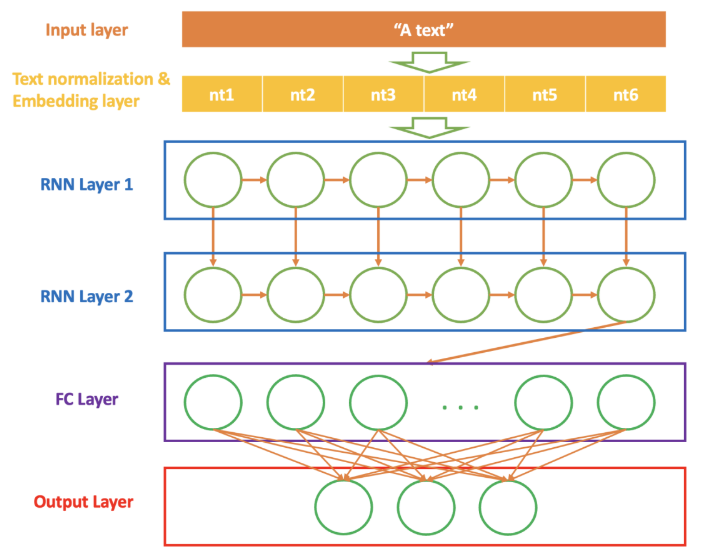

In [101]:
class SentimentClassifier(nn.Module):
  def __init__(
      self, vocab_size, embedding_dims,
      hidden_size, n_layers, n_classes,
      dropout_prob
  ):
    super(SentimentClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dims)
    self.gru = nn.GRU(
        embedding_dims, hidden_size, n_layers,
        batch_first=True, bidirectional= True
    )
    self.norm = nn.LayerNorm(2*hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc1 = nn.Linear(2*hidden_size, 16)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(16, n_classes)

  def forward(self, x):
    x = self.embedding(x)
    x, _ = self.gru(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

##Init model

In [102]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
droput_prob = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dims=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=droput_prob
).to(device)

In [103]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

##Training function

In [79]:
def evaluate(model, criterion, data_loader, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  loss = sum(losses)/len(losses)
  accuracy = correct / total
  return loss, accuracy

In [80]:
def fit(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    device,
    epochs
):
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  for epoch in range(epochs):
    batch_train_losses = []
    correct = 0
    total = 0
    model.train()
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      batch_train_losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    train_loss = sum(batch_train_losses)/len(batch_train_losses)
    train_losses.append(train_loss)
    train_acc = correct / total
    train_accs.append(train_acc)

    val_loss, val_acc = evaluate(model, criterion, val_loader, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    print('-'*50)

  return train_losses, val_losses, train_accs, val_accs

##Train model

In [104]:
train_losses, val_losses, train_accs, val_accs = fit(
    model,
    criterion,
    optimizer,
    train_dataloader,
    val_dataloader,
    device,
    epochs
)

Epoch 1/50
Train Loss: 1.0276 | Train Acc: 0.4707
Val Loss: 0.9377 | Val Acc: 0.5773
--------------------------------------------------
Epoch 2/50
Train Loss: 0.9353 | Train Acc: 0.5836
Val Loss: 0.9315 | Val Acc: 0.5814
--------------------------------------------------
Epoch 3/50
Train Loss: 0.9298 | Train Acc: 0.5868
Val Loss: 0.9303 | Val Acc: 0.5845
--------------------------------------------------
Epoch 4/50
Train Loss: 0.9309 | Train Acc: 0.5898
Val Loss: 0.9291 | Val Acc: 0.5897
--------------------------------------------------
Epoch 5/50
Train Loss: 0.9296 | Train Acc: 0.5892
Val Loss: 0.9282 | Val Acc: 0.5907
--------------------------------------------------
Epoch 6/50
Train Loss: 0.9273 | Train Acc: 0.5922
Val Loss: 0.9278 | Val Acc: 0.5928
--------------------------------------------------
Epoch 7/50
Train Loss: 0.9271 | Train Acc: 0.5907
Val Loss: 0.9271 | Val Acc: 0.5928
--------------------------------------------------
Epoch 8/50
Train Loss: 0.9261 | Train Acc: 0.594

##Visualize

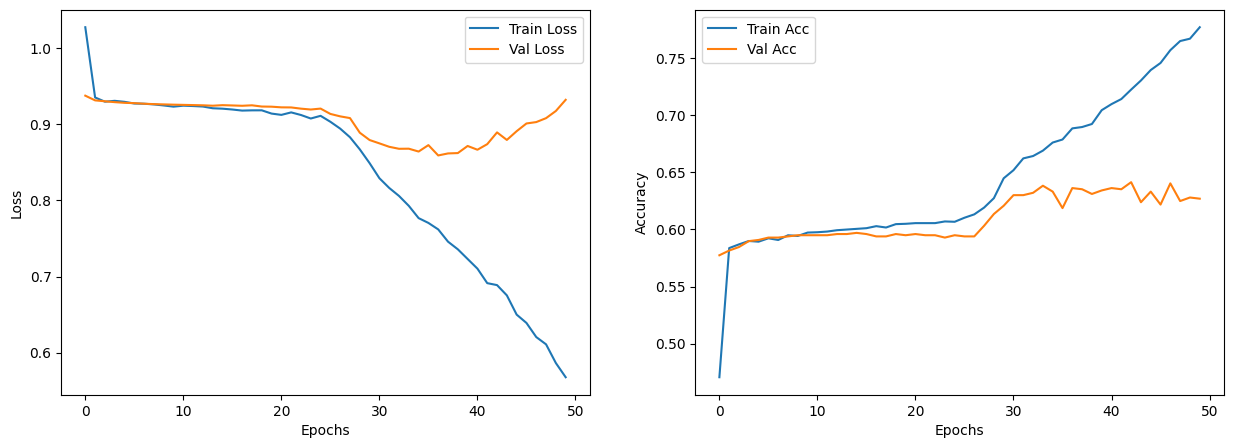

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(val_losses, label='Val Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_accs, label='Train Acc')
ax[1].plot(val_accs, label='Val Acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

##Evaluate

In [106]:
_, test_acc = evaluate(model, criterion, test_dataloader, device)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.6082


##Inference

In [112]:
def inference(model, text, tokenizer, device):
  model.eval()
  text = normalize_text(text)
  text = transform(text, word_to_idx, max_seq_len)
  text = torch.tensor(text)
  # Add an unsqueeze operation to create a batch dimension:
  text = text.unsqueeze(0).to(device) # Reshape to (1, seq_len) for batch processing
  output = model(text)
  _, predicted = torch.max(output.data, 1)
  if predicted.item() == 0:
    return 'Negative'
  elif predicted.item() == 1:
    return 'Neutral'
  else:
    return 'Positive'

text = 'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .'
print(inference(model, text, word_to_idx, device))

Positive
